# DYNASTY - SHRED: validation on parametric transients

This notebook implements the SHRED architecture to the RELAP5 of the DYNASTY facility, considering the case in which model data are available for training and real experimental data are used during the test/online phase.

This serves as validation of the SHRED architecture on parametric unseen data coming from a real facility.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

Let us import the data

In [2]:
path_snaps = '../../NuSHRED_Datasets/D3/parametric_dataset.npz'

data = np.load(path_snaps, allow_pickle=True)

# Load the data
snap_data_dict = data['snaps'].item()
param_mu = data['param_mu']
simulation_time = data['simulation_time']
target_idx = data['target_idx']

var_names = list(snap_data_dict.keys())

Nt = len(simulation_time)
ntrajectories = len(param_mu)
N_params = param_mu.shape[1] # P and h

assert ntrajectories == snap_data_dict[var_names[0]].shape[0]
assert Nt == snap_data_dict[var_names[0]].shape[1]
Nh = snap_data_dict[var_names[0]].shape[2]

print('Number of snapshots:      ', ntrajectories)
print('Number of time steps:     ', Nt)
print('Number of spatial points: ', Nh)

Number of snapshots:       121
Number of time steps:      201
Number of spatial points:  122


Let us split the snapshots into train, test and valid

In [3]:
np.random.seed(10)
ntrain = int(0.8 * ntrajectories)

idx_train = np.random.choice(ntrajectories, size = ntrain, replace = False)
mask = np.ones(ntrajectories)
mask[idx_train] = 0
idx_valid_test = np.arange(0, ntrajectories)[np.where(mask!=0)[0]]

# Ensure the (power = 35.5, htc = 65) case is in the test set
target_case = (35.5, 65.0)
target_idx = np.where((param_mu[:, 0] == target_case[0]) & (param_mu[:, 1] == target_case[1]))[0][0]

# Remove the target case from the training set if it's included
if target_idx in idx_train:
    idx_train = idx_train[idx_train != target_idx]
    ntrain -= 1

idx_test = np.append(idx_valid_test[1::2], target_idx)
idx_valid = np.setdiff1d(idx_valid_test, idx_test)
assert target_idx in idx_test, "The target case is not in the test set."

nvalid = idx_valid.shape[0]
ntest = idx_test.shape[0]

dataset = dict()
for field in snap_data_dict.keys():
    dataset[field] = {
        'train': np.asarray([snap_data_dict[field][idx] for idx in idx_train]),
        'valid': np.asarray([snap_data_dict[field][idx] for idx in idx_valid]),
        'test':  np.asarray([snap_data_dict[field][idx] for idx in idx_test]),
    }

_mu = np.zeros((ntrajectories, Nt, N_params))
for idx in range(ntrajectories):
    _mu[idx] = np.tile(param_mu[idx], (Nt, 1))

dataset['params'] = {
    'train': _mu[idx_train],
    'valid': _mu[idx_valid],
    'test':  _mu[idx_test],
}

Let us plot the parameter space

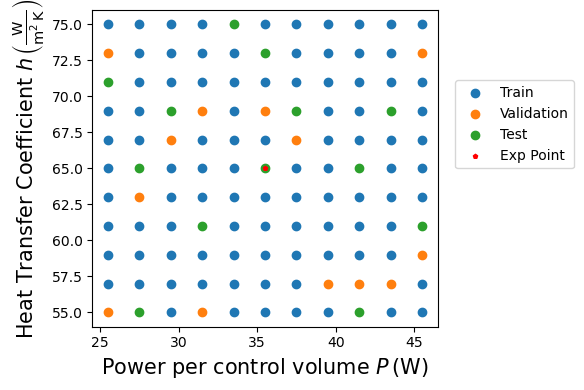

In [4]:
import os

path_res = 'Test_Results/ParametricValidation/'
os.makedirs(path_res, exist_ok=True)

fig, axs = plt.subplots(1, 1, figsize=(6, 4))

axs.scatter(dataset['params']['train'][:, 0, 0], dataset['params']['train'][:, 0, 1], label='Train')
axs.scatter(dataset['params']['valid'][:, 0, 0], dataset['params']['valid'][:, 0, 1], label='Validation')
axs.scatter(dataset['params']['test'][:,  0, 0], dataset['params']['test'][:,  0, 1], label='Test')

axs.scatter(param_mu[target_idx, 0], param_mu[target_idx, 1], s=10, marker='p', color='red', label='Exp Point')

axs.set_xlabel(r'Power per control volume $P\,$(W)', fontsize=15)
axs.set_ylabel(r'Heat Transfer Coefficient $h\,\left(\frac{\text{W}}{\text{m}^2\, \text{K}}\right)$', fontsize=15)
axs.legend(ncols=1, loc=(1.05,0.5))   
plt.tight_layout()

fig.savefig(path_res+'parametric_space.pdf', dpi=300, bbox_inches='tight')

Defining the spatial domain and the index of the fluid thermocouples

In [5]:
domain = np.arange(0, Nh, 1)

# Define experimental index
exp_idx = np.array([1, 25, 55, 92]) - 1

## Singular Value Decomposition
The data are reduced using the Singular Value Decomposition (SVD)

In [6]:
from scalers import MyScaler
from sklearn.utils.extmath import randomized_svd

rescaling_snaps = list()
Nmodes = []

u_total = dict()
s_total = dict()

modes_number = [10]

for field_i, field in enumerate(var_names):
    u = dataset[field]['train'].reshape(-1, Nh).T
    
    rescaling_snaps.append(MyScaler())
    rescaling_snaps[field_i].fit(u.T)
    
    X = rescaling_snaps[field_i].transform(u.T).T

    assert X.shape[0] == Nh
    assert X.shape[1] == Nt * ntrain
    
    _Nmodes = modes_number[field_i]
    
    Nmodes.append(_Nmodes)
    
    u_svd, s_svd, v_svd = randomized_svd(X, n_components = _Nmodes, n_iter = 'auto')

    if field_i == 0:
        v_total = v_svd
    else:
        v_total = np.vstack((v_total, v_svd))
        
    s_total[field] = s_svd.flatten()
    u_total[field] = u_svd
        
Nmodes = np.asarray(Nmodes)

/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value encountered in matmul
  Q, _ = no

Let us plot the sing vals

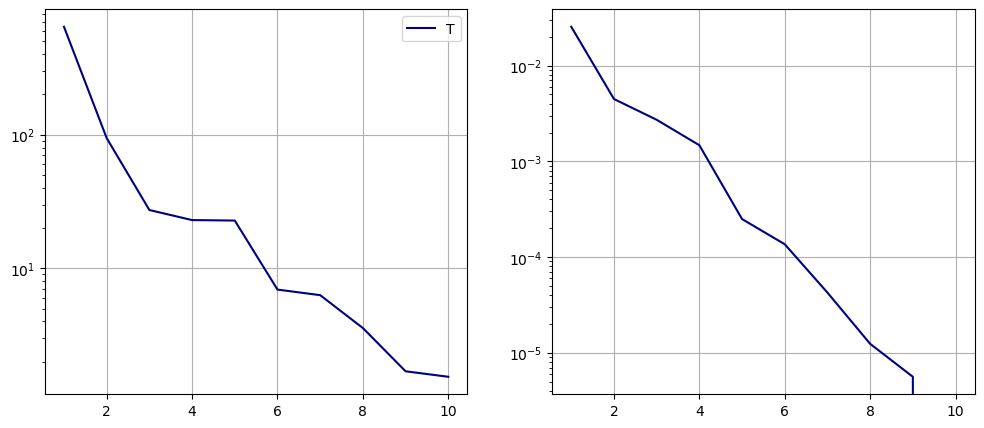

In [7]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, sharex=True, figsize=(12,5))

colors = cm.jet(np.linspace(0,1,len(var_names)))
for field_i, field in enumerate(var_names):
    N_plot = np.arange(1, Nmodes[field_i]+1, 1)
    axs[0].semilogy(N_plot, s_total[field], color=colors[field_i], label=field)
    axs[1].semilogy(N_plot, 1-np.cumsum(s_total[field]**2) / np.sum(s_total[field]**2), color=colors[field_i], label=field)
axs[0].grid()
axs[1].grid()
axs[0].legend()

Check the train, test and valid error

In [8]:
for field_i in range(len(var_names)):
    field = var_names[field_i]

    for key in dataset[field].keys():
        true_field = rescaling_snaps[field_i].transform(dataset[field][key].reshape(-1, Nh)).T

        _coeff_POD = np.linalg.multi_dot([
            np.linalg.inv(np.diag(s_total[field])), u_total[field].T, true_field
        ]).T
        rec = np.linalg.multi_dot([u_total[field], np.diag(s_total[field]), _coeff_POD.T])
        errors = np.linalg.norm(rec - true_field, axis = 0) / np.linalg.norm(true_field, axis=0)

        print(field + ' - '+key)
        print('   max = {:.3e}'.format(np.max(errors)) +' and ave {:.3e}'.format(np.mean(errors)))

T - train
   max = 7.366e-02 and ave 9.062e-03
T - valid
   max = 7.367e-02 and ave 9.180e-03
T - test
   max = 7.367e-02 and ave 9.140e-03


Let us store the POD coefficients

In [9]:
_v_POD = dict()

for field in var_names:
    _v_POD[field] = { key: np.linalg.multi_dot([np.linalg.inv(np.diag(s_total[field])),  u_total[field].T, rescaling_snaps[field_i].transform(dataset[field][key].reshape(-1, Nh)).T])
                        for key in  dataset[field].keys()
                    }

Let us reshape the coefficients

In [10]:
n_separation = {
    'train': ntrain,
    'test':  ntest,
    'valid': nvalid
}

v_POD = dict()
for key in list(n_separation.keys()):
    v_POD[key] = np.concatenate([_v_POD[var_names[field_i]][key].T.reshape(n_separation[key], Nt, Nmodes[field_i]) 
                                for field_i in range(len(var_names))], axis=-1)

print(v_POD['train'].shape)
print(v_POD['valid'].shape)
print(v_POD['test'].shape)

(95, 201, 10)
(13, 201, 10)
(13, 201, 10)


## Compute Measures
The positions of the sensors are sampled from the experimental ones

In [11]:
measured_field = 0

from tqdm import tqdm
num_sensors = 3
sensor_locations = np.arange(0, num_sensors, 1, dtype=int) # [0,1,2]

n_configurations = 1
idx_sensor_locations = np.zeros((num_sensors, n_configurations), dtype=int)
sensors = list()

snap_measurements = list()

for kk in tqdm(range(n_configurations), 'Creating sensors'):

    np.random.seed(1)
    idx_sensor_locations[:, kk] = np.asarray(np.random.choice(exp_idx, size=num_sensors, replace=False), dtype=int)

    snap_measurements.append({
        key: dataset[var_names[measured_field]][key][:, :, idx_sensor_locations[:,kk]]
        for key in list(dataset[var_names[measured_field]].keys())
    })

Creating sensors: 100%|██████████| 1/1 [00:00<00:00, 965.32it/s]


Let us plot the different configurations of sensors

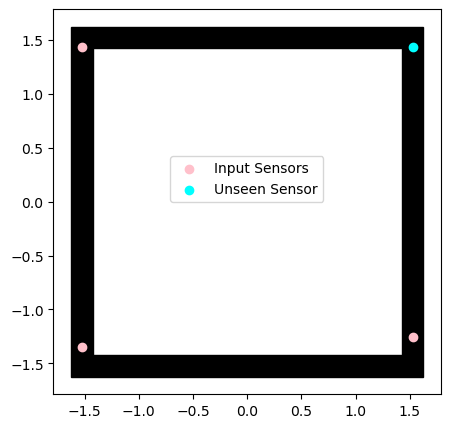

In [12]:
from plots import add_tubes, extract_dynasty_coordinates
import matplotlib.colors as mcolors

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5))

x_dyn, y_dyn = extract_dynasty_coordinates()

add_tubes(axs, _s = 0.1, facecolors=['black', 'white'])

# cmap = cm.rainbow
# colors = cmap(np.linspace(0,1,n_configurations))
colors = ['pink']
for kk in range(n_configurations):
    axs.scatter(x_dyn[idx_sensor_locations[:, kk]], y_dyn[idx_sensor_locations[:, kk]], color=colors[kk], label='Input Sensors')
axs.scatter(x_dyn[exp_idx[1]], y_dyn[exp_idx[1]], color='cyan', label='Unseen Sensor')
axs.legend(ncols=1, loc=(0.3,0.5))

fig.savefig(path_res+'sensors.pdf', format='pdf', dpi=250, bbox_inches='tight')

Let us add noise to the measures

In [13]:
noise_value = 0.5/100
Xsensor = list()

for kk in range(n_configurations):
    Xsensor.append({
        key: snap_measurements[kk][key] * (1+np.random.normal(scale=noise_value, size=snap_measurements[kk][key].shape))
        for key in list(snap_measurements[kk].keys())
    })

print('Sensors Shape')
print(Xsensor[0]['train'].shape)
print(Xsensor[0]['test'].shape)
print(Xsensor[0]['valid'].shape)

Sensors Shape
(95, 201, 3)
(13, 201, 3)
(13, 201, 3)


Let us plot some configurations

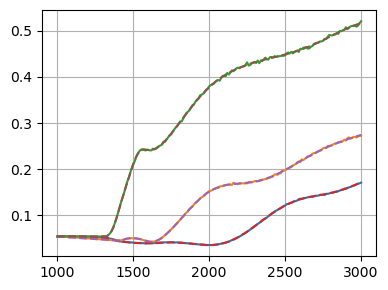

In [14]:
ncols = 1
nrows = 1
fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, sharey=True, figsize= (4 * ncols, 3 * nrows))
axs = np.array(axs).reshape(-1)

idx_mu = 45
for kk in range(nrows * ncols):
    axs[kk].plot(simulation_time, Xsensor[kk]['train'][idx_mu], label='Spline')
    axs[kk].plot(simulation_time, snap_measurements[kk]['train'][idx_mu], '--', label='FOM')
    axs[kk].grid()
    
plt.tight_layout()

Let us scale them to be in the range $[0, 1]$

In [15]:
from sklearn.preprocessing import MinMaxScaler

rescaled_Xsensor = list()
sens_scaler = list()
for kk in range(n_configurations):
    sens_scaler.append(MinMaxScaler())
    sens_scaler[kk].fit(Xsensor[kk]['train'].reshape(-1, num_sensors))

    rescaled_Xsensor.append({
        key: sens_scaler[kk].transform(Xsensor[kk][key].reshape(-1, num_sensors)).reshape(Xsensor[kk][key].shape)
        for key in list(Xsensor[kk].keys())
    })

print('Rescaled Sensors Shape')
print(rescaled_Xsensor[0]['train'].shape)
print(rescaled_Xsensor[0]['test'].shape)
print(rescaled_Xsensor[0]['valid'].shape)

Rescaled Sensors Shape
(95, 201, 3)
(13, 201, 3)
(13, 201, 3)


## Padding
In this section, the data are prepared to be fed into the SHRED architecture.

At first, let us load the POD coefficients and let us rescale them between 0 and 1.

In [16]:
assert sum(Nmodes) == v_POD['train'].shape[2]

vpod_scaler = MinMaxScaler()
vpod_scaler.fit(v_POD['train'].reshape(-1, sum(Nmodes)))

rescaled_v_POD = {
    key: vpod_scaler.transform(v_POD[key].reshape(-1, sum(Nmodes))).reshape(v_POD[key].shape)
    for key in list(v_POD.keys())
}

Let us create the parameters data

In [17]:
param_scaler = MinMaxScaler()
param_scaler.fit(dataset['params']['train'].reshape(-1, N_params))

rescaled_parameters = {
    key: param_scaler.transform(dataset['params'][key].reshape(-1, N_params)).reshape(dataset['params'][key].shape)
    for key in list(dataset['params'].keys())
}

print('Params Shape')
print(rescaled_parameters['train'].shape)
print(rescaled_parameters['test'].shape)
print(rescaled_parameters['valid'].shape)

print('POD Coeff Shape')
print(rescaled_v_POD['train'].shape)
print(rescaled_v_POD['test'].shape)
print(rescaled_v_POD['valid'].shape)

Params Shape
(95, 201, 2)
(13, 201, 2)
(13, 201, 2)
POD Coeff Shape
(95, 201, 10)
(13, 201, 10)
(13, 201, 10)


Then, let us prepare them for the SHRED architecture

In [18]:
import sys
sys.path.append('../../')

from shred.processdata import Padding, TimeSeriesDataset
import torch

## GPU
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')

lags = 30

# Input Data
train_data_in = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['train']), lags).to(device) for kk in range(n_configurations)]
valid_data_in = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['valid']), lags).to(device) for kk in range(n_configurations)]
test_data_in  = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['test']), lags).to(device)  for kk in range(n_configurations)]

# Output Data
train_data_out = Padding(torch.cat((torch.from_numpy(rescaled_v_POD['train']), 
                                     torch.from_numpy(rescaled_Xsensor[kk]['train'])), 
                                     axis=2), 1).squeeze(1).to(device)

valid_data_out = Padding(torch.cat((torch.from_numpy(rescaled_v_POD['valid']), 
                                     torch.from_numpy(rescaled_Xsensor[kk]['valid'])), 
                                     axis=2), 1).squeeze(1).to(device)

test_data_out = Padding(torch.cat((torch.from_numpy(rescaled_v_POD['test']), 
                                     torch.from_numpy(rescaled_Xsensor[kk]['test'])), 
                                     axis=2), 1).squeeze(1).to(device)
output_size = sum(Nmodes) + num_sensors

# Create Dataset for SHRED training
train_dataset = [TimeSeriesDataset(train_data_in[kk], train_data_out) for kk in range(n_configurations)]
valid_dataset = [TimeSeriesDataset(valid_data_in[kk], valid_data_out) for kk in range(n_configurations)]
test_dataset  = [TimeSeriesDataset(test_data_in[kk],  test_data_out)  for kk in range(n_configurations)]

## SHRED
Let us train the SHRED models for each configuration

In [76]:
from shred.models import SHRED, fit

train_net = False

shred = list()
for kk in range(n_configurations):
    
    shred.append(SHRED( num_sensors, output_size, 
                        hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device))

    if train_net:
        print('Training SHRED - configuration '+str(kk+1)+'/'+str(n_configurations))

        fitting_errors = fit(   shred[kk], train_dataset[kk], valid_dataset[kk], 
                                batch_size = 64, epochs = 3000, lr = 1e-3, verbose = True, patience = 25)

        shred[kk].freeze()
        torch.save(shred[kk].state_dict(), path_res+'trained_config'+str(kk)+'_measuring_'+str(num_sensors)+'sens_'+var_names[measured_field]+'.shred')
        print(' ')
    else:
        shred[kk].load_state_dict(torch.load(path_res+'trained_config'+str(kk)+'_measuring_'+str(num_sensors)+'sens_'+var_names[measured_field]+'.shred',
                                             map_location=device))
        shred[kk].freeze()
    

### Testing SHRED
In this section, the reliability of the SHRED network are assessed.

We generate reconstructions from the test set and print mean square error compared to the ground truth.

**Uncertainty Quantification**: the mean and the standard deviation of the output of each configuration of SHRED models is computed.

In [77]:
from shred.processdata import num2p, mre

Ytest_POD_hat = torch.stack([shred[kk](test_data_in[kk]) for kk in range(n_configurations)], dim=0)

Ytest_POD_pred = {
    'mean': Ytest_POD_hat.mean(axis=0),
    'std':  Ytest_POD_hat.std(axis=0) / np.sqrt(n_configurations)
}

# The test data are independent on the configurations of the sensors
print("Mean relative SHRED prediction error on POD coeffs: %s." % num2p(mre(test_data_out,  Ytest_POD_pred['mean'])))

Mean relative SHRED prediction error on POD coeffs: 1.62%.


Let us reshape the output of the SHRED models and the associated test data to simplify the access to the variables.

In fact, the output of the SHRED models is a 2D array with dimensions $N_p^{test}\cdot N_t \times (R+N_{params})$, given $N_p$ the number of elements in the parameter test set, $N_t$ the number of time steps, $R$ the number of total rank of the latent space and $N_{params}$ the number of parameters (only 1, since $\tau$ only has been considered).

In [78]:
idx_params = {
    'train': idx_train,
    'valid': idx_valid,
    'test':  idx_test
}

reshaped_test_out = test_data_out.cpu().detach().numpy()[:, :-num_sensors].reshape(len(idx_params['test']), Nt, sum(Nmodes))

reshaped_POD_test_out = {
    'mean': Ytest_POD_pred['mean'].cpu().detach().numpy()[:, :-num_sensors].reshape(len(idx_params['test']), Nt, sum(Nmodes)),
    'std':  Ytest_POD_pred['std'].cpu().detach().numpy()[:, :-num_sensors].reshape(len(idx_params['test']), Nt, sum(Nmodes))
}

Let us plot the first 5 temporal dynamical the reduced coefficients for each field

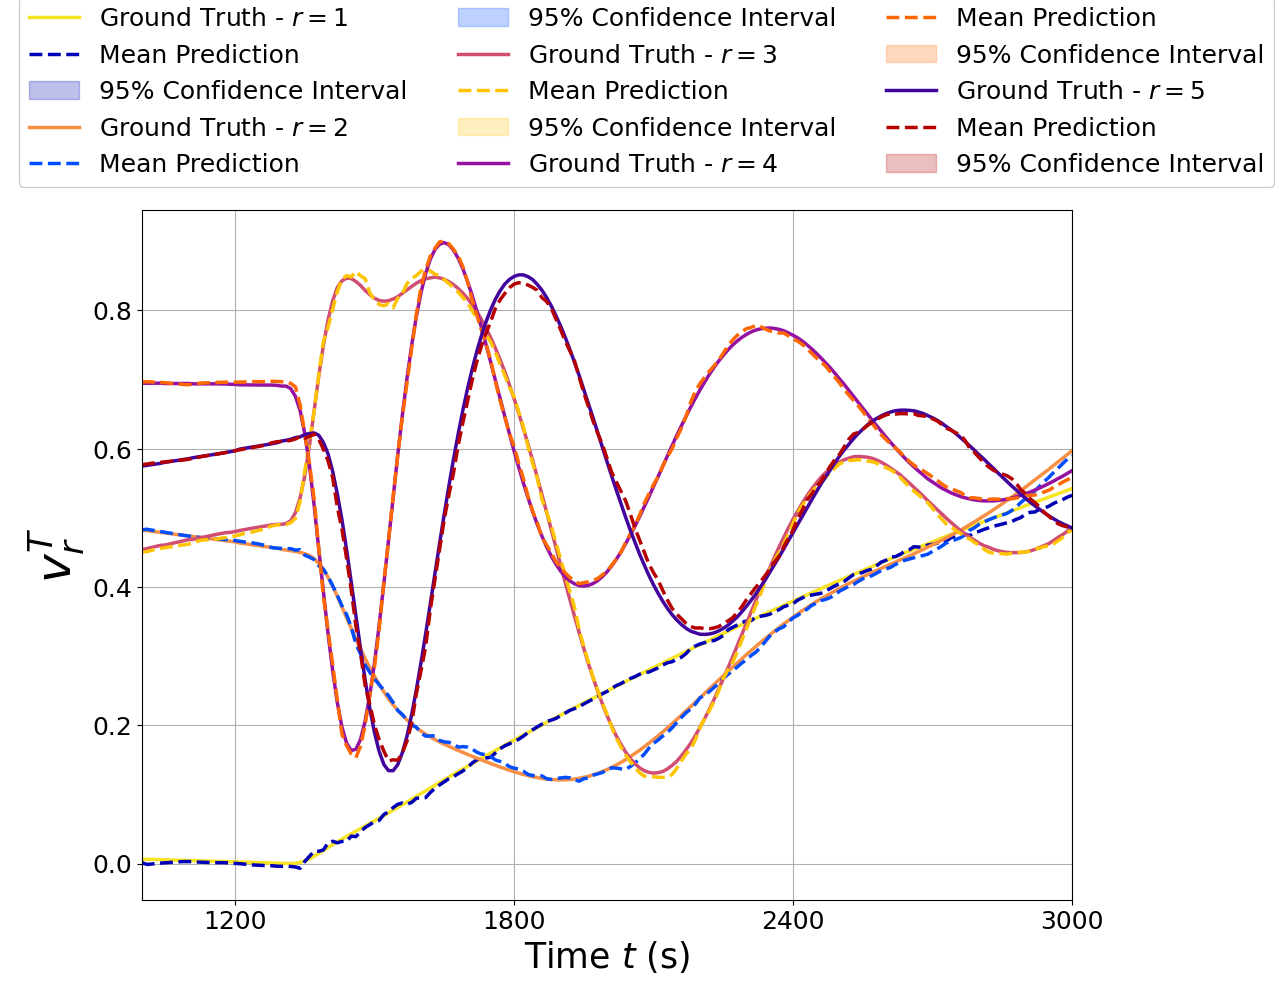

In [ ]:
modes_to_plot = 5
param_to_plot = 2

nrows = 1
ncols = 1
fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, figsize=(12 * ncols, 10 * nrows))
axs = np.array([axs]).reshape(-1)

ls = 2.5

for field_i, field in enumerate(var_names):

    idx_to_plot = np.arange(sum(Nmodes[:field_i]),
                            modes_to_plot + sum(Nmodes[:field_i]),
                            1, 
                            dtype=int)

    # colors = cm.jet(np.linspace(0.,1,len(idx_to_plot)))
    colors = cm.jet([0.05, 0.2, 0.7, 0.8, 0.95])
    colors_gt = cm.plasma(np.linspace(0.1,0.95,len(idx_to_plot)))
    for ii, idx in enumerate(idx_to_plot):
        axs[field_i].plot(simulation_time, reshaped_test_out[param_to_plot, :, idx], '-', linewidth=ls, c=colors_gt[-1-ii], label=r'Ground Truth - $r='+str(ii+1)+'$')

        axs[field_i].plot(simulation_time, reshaped_POD_test_out['mean'][param_to_plot, :, idx], '--', c=colors[ii], label=r'Mean Prediction', linewidth=ls)
        # axs[field_i].fill_between(  simulation_time, 
        #                             y1 = reshaped_POD_test_out['mean'][param_to_plot, :, idx] - 1.96 * reshaped_POD_test_out['std'][param_to_plot, :, idx],
        #                             y2 = reshaped_POD_test_out['mean'][param_to_plot, :, idx] + 1.96 * reshaped_POD_test_out['std'][param_to_plot, :, idx],
        #                             color=colors[ii], alpha=0.25, label=r'95% Confidence Interval')

    axs[field_i].set_ylabel(r'$v_r^{'+var_names[field_i]+r'}$', fontsize=35)
    axs[field_i].grid()

    axs[field_i].set_xticks(np.arange(0,3601.0001, 600))
    axs[field_i].set_xlim(min(simulation_time), max(simulation_time))
    axs[field_i].tick_params(axis='both', labelsize=18)
    # axs[field_i].legend(loc=(1.025, 0.35), ncols=2)
    
Line, Label = axs[0].get_legend_handles_labels()
fig.legend(Line, Label, fontsize=18, ncols=3, framealpha=1, loc=(0.015, 0.81))

axs = axs.reshape(nrows, ncols)
[ax.set_xlabel(r'Time $t$ (s)', fontsize=25) for ax in axs[-1]]

fig.subplots_adjust(hspace=0.1, top = 0.8, wspace=0.175)
fig.savefig(path_res+'SHRED_dynamics_uq.pdf', format='pdf', dpi=250, bbox_inches='tight')

Let us compare the POD coefficients for the different values of $\boldsymbol{\mu}$ for selected fields

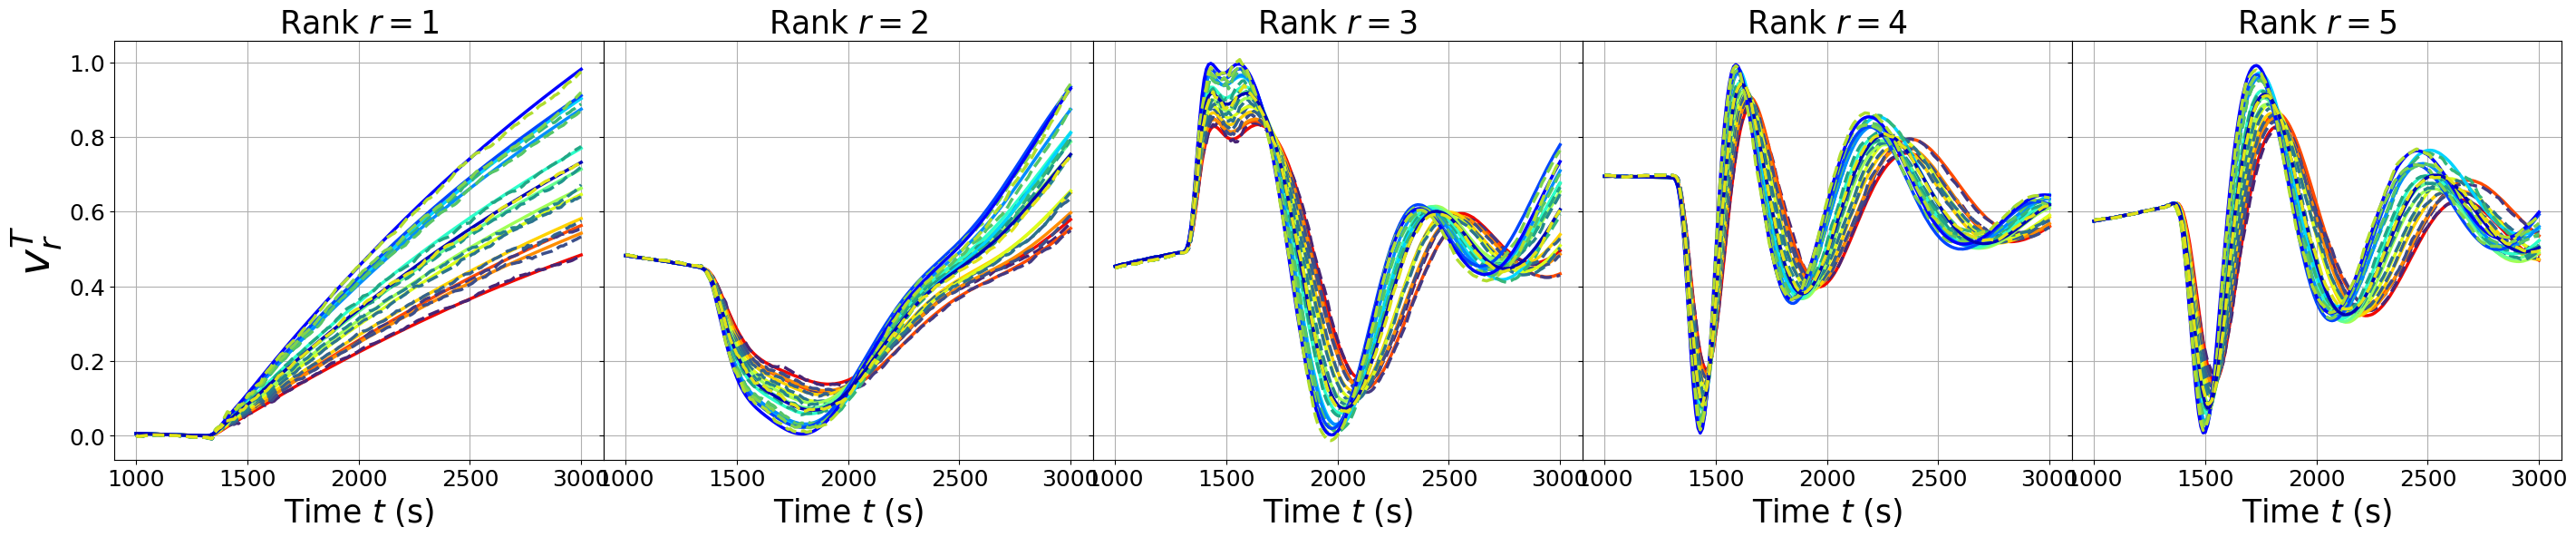

In [80]:
fields_idx_to_plot = [0]

nrows = len(fields_idx_to_plot)
ncols = modes_to_plot

fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, sharey=True, figsize=(6 * ncols, 6 * nrows))
axs = np.array([axs]).reshape(nrows, ncols)
ls = 2.5

for ii, field_i in enumerate(fields_idx_to_plot):
    idx_to_plot = np.arange(sum(Nmodes[:field_i]),
                            modes_to_plot + sum(Nmodes[:field_i]),
                            1, 
                            dtype=int)

    colors = cm.viridis(np.linspace(0.1,0.95,len(idx_params['test'])))
    colors_gt = cm.jet_r(np.linspace(0.1,0.95,len(idx_params['test'])))

    for jj, idx in enumerate(idx_to_plot):
        for param_to_plot in range(len(idx_params['test'])):
            axs[ii, jj].plot(simulation_time, reshaped_test_out[param_to_plot,:,idx],
                            '-', linewidth=ls, c=colors_gt[param_to_plot], label=r'Ground Truth - $\boldsymbol{\mu}^{'+str(idx_params['test'][param_to_plot])+'}$')
            axs[ii, jj].plot(simulation_time, reshaped_POD_test_out['mean'][param_to_plot,:,idx],
                                '--', c=colors[param_to_plot], label=r'Mean - $\boldsymbol{\mu}^{'+str(idx_params['test'][param_to_plot])+'}$', linewidth=ls)
            axs[ii, jj].fill_between(simulation_time,
                                    y1 = reshaped_POD_test_out['mean'][param_to_plot,:,idx] - 1.96 * reshaped_POD_test_out['std'][param_to_plot,:,idx],
                                    y2 = reshaped_POD_test_out['mean'][param_to_plot,:,idx] + 1.96 * reshaped_POD_test_out['std'][param_to_plot,:,idx],
                                    color=colors[param_to_plot], alpha=0.25)
        axs[ii,jj].grid()
        axs[ii,jj].tick_params(axis='both', labelsize=18)
    
[axs[0, jj].set_title(r'Rank $r='+str(jj+1)+'$', fontsize=25) for jj in range(ncols)]
[axs[ii, 0].set_ylabel(r'$v_r^{'+var_names[fields_idx_to_plot[ii]]+r'}$', fontsize=35) for ii in range(nrows)]
[axs[-1, jj].set_xlabel(r'Time $t$ (s)', fontsize=25) for jj in range(ncols)]

# Line, Label = axs[0,0].get_legend_handles_labels()
# fig.legend(Line, Label, fontsize=18, ncols=8, framealpha=1, loc=(0.15, 0.81))

fig.subplots_adjust(left=0, hspace=0.0, wspace=0.)
fig.savefig(path_res+'SHRED_dynamics_test_parameters.pdf', format='pdf', dpi=250, bbox_inches='tight')

### Decoding to High-Dimensional Space
Let us decode the output of the SHRED models to the high-dimensional space.

The error is computed using the Euclidian norm

In [81]:
from tqdm import tqdm

ave_rel_errors = {
    'mean': np.zeros((len(var_names), len(idx_params['test']), Nt)),
    'std' : np.zeros((len(var_names), len(idx_params['test']), Nt))
}

for field_i in range(len(var_names)):
    field = var_names[field_i]
    idx_to_rec = np.arange(sum(Nmodes[:field_i]),  sum(Nmodes[:field_i+1]),  1, dtype=int)

    for param_to_recon in tqdm(range(len(idx_params['test'])), 'Computing error for '+field):
        fom = dataset[field]['test'][param_to_recon].T

        _tmp_mean_v = vpod_scaler.inverse_transform(reshaped_POD_test_out['mean'].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'].shape)
        _tmp_std_v  = vpod_scaler.inverse_transform(reshaped_POD_test_out['std'].reshape( -1, sum(Nmodes))).reshape(reshaped_POD_test_out['std'].shape) - vpod_scaler.data_min_

        recon     = rescaling_snaps[field_i].inverse_transform((u_total[field] @ np.diag(s_total[field]) @ _tmp_mean_v[param_to_recon, :, idx_to_rec]).T).T
        std_recon = rescaling_snaps[field_i].inverse_std_transform((u_total[field] @ np.diag(s_total[field]) @ _tmp_std_v[ param_to_recon, :, idx_to_rec]).T).T

        ave_rel_errors['mean'][field_i, param_to_recon] = np.linalg.norm(fom - recon, axis=0) / np.linalg.norm(fom, axis=0)
        ave_rel_errors['std'][field_i, param_to_recon]  = np.linalg.norm(std_recon, axis=0)   / np.linalg.norm(fom, axis=0)

Computing error for T: 100%|██████████| 13/13 [00:00<00:00, 1278.12it/s]


Let us plot the errors using bar plots

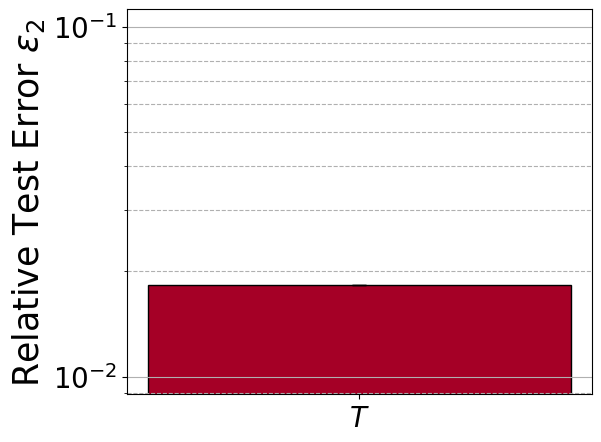

In [82]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(6,5))

colors = cm.jet(np.linspace(0,1, len(var_names)))
axs.bar(np.arange(1, len(var_names)+1, 1), np.mean(ave_rel_errors['mean'], axis=(1, 2)).mean(), 
        yerr = np.mean(ave_rel_errors['mean'], axis=(1, 2)).std(), capsize=5,
        color = cm.RdYlBu(np.linspace(0,1,len(var_names))),
        edgecolor='k')

axs.set_yscale('log')
axs.set_xticks(np.arange(1,len(var_names)+1,1), ['$'+tex_+'$' for tex_ in var_names])
# axs.set_yticks(np.arange(0,0.1,0.01))

axs.tick_params(axis='both', labelsize=20)
axs.set_ylabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=25)
axs.grid(axis='y', linestyle='-')
axs.grid(axis='y', which='minor', linestyle='--')

fig.savefig(path_res+'fom_relativerrror_bars.pdf', format='pdf', dpi=250, bbox_inches='tight')

## Validation with Experimental Data
Within the test set, there is a configuration in which Experimental data are available.

Let us observe how the SHRED models perform on this configuration, using as sensor input the real data.

In [83]:
exp_data = np.load('../../NuSHRED_Datasets/D3/exp_data.npz')
exp_data = {
    'Time': exp_data['Time'][740:2400:1],
    'TC': exp_data['TC'][:, 740:2400:1],
} # elements in the training time are selected

# This function is used to extract the configuration from the exp measures
def convert_to_order(exp_idx, idx_sensor_locations):
    idx_map = {value: idx for idx, value in enumerate(exp_idx)}
    order_matrix = np.vectorize(idx_map.get)(idx_sensor_locations)
    
    return order_matrix
order_idx_sens = convert_to_order(exp_idx, idx_sensor_locations)

Let us make the experimental time match the simulation time

In [84]:
_tmp = np.zeros((exp_data['TC'].shape[0], simulation_time.shape[0]))
for ii in range(_tmp.shape[0]):
    _tmp[ii] = np.interp(simulation_time, exp_data['Time'], exp_data['TC'][ii])

exp_data['TC'] = _tmp
exp_data['Time'] = simulation_time

Let us extract the measures consistently with the SHRED selection and let us rescale them.

In [85]:
new_Xsensor = np.zeros((n_configurations, 1, len(exp_data['Time']), num_sensors))
rescaled_Xsensor = list()

for kk in range(n_configurations):
    for jj in range(num_sensors):
        new_Xsensor[kk, 0, :, jj] = exp_data['TC'][order_idx_sens[jj, kk]]
    rescaled_Xsensor.append(sens_scaler[kk].transform(new_Xsensor[kk].reshape(-1, num_sensors)).reshape(new_Xsensor[kk].shape))

print('Rescaled Sensors Shape')
print(rescaled_Xsensor[0].shape)

Rescaled Sensors Shape
(1, 201, 3)


Let us create the sequence using the Padding function

In [86]:
test_data_exp_in = [Padding(torch.from_numpy(rescaled_Xsensor[kk]), lags).to(device) for kk in range(n_configurations)]

Let us reconstruct the output using the SHRED models

In [87]:
test_data_exp_out = torch.stack([shred[kk](test_data_exp_in[kk]) for kk in range(n_configurations)], dim=0)

reshaped_POD_test_exp_out = {
    'mean': test_data_exp_out.mean(axis=0).cpu().detach().numpy()[:, :-num_sensors:].reshape(new_Xsensor[0].shape[0],new_Xsensor[0].shape[1], sum(Nmodes)),
}

Let us plot the results

In [88]:
from plots import plot_loop_FOM_vs_SHRED

path_fig = path_res+'FigsExp/'
os.makedirs(path_fig, exist_ok=True)

param_to_plot = -1
field = var_names[0]

fom = dataset[field]['test'][param_to_plot].T
fom_upscaled = np.zeros((fom.shape[0], exp_data['Time'].shape[0]))
for ii in range(fom.shape[0]):
    fom_upscaled[ii] = np.interp(exp_data['Time'], simulation_time, fom[ii])

# Reconstruct the FOM
idx_to_rec = np.arange(sum(Nmodes[:field_i]),  sum(Nmodes[:field_i+1]),  1, dtype=int)
_tmp_mean_v = vpod_scaler.inverse_transform(reshaped_POD_test_exp_out['mean'].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_exp_out['mean'].shape)

recon     = rescaling_snaps[field_i].inverse_transform((u_total[field] @ np.diag(s_total[field]) @ _tmp_mean_v[param_to_plot, :, idx_to_rec]).T).T

for time_idx in tqdm(range(0, len(exp_data['Time']), 5)):
    filename = path_fig+'SHRED_TC_time{:.2f}.png'.format(exp_data['Time'][time_idx])

    _fig = plot_loop_FOM_vs_SHRED(  fom_upscaled, recon, exp_data['Time'], time_idx, 0,
                                    exp_idx, std_shred=None, exp_data=exp_data,
                                    lims = [exp_data['TC'].min(), exp_data['TC'].max()],
                                    cmap = cm.jet, sampling_exp=2)

    unselected_value = np.setdiff1d(exp_idx, idx_sensor_locations)[0]
    unselected_position = np.where(exp_idx == unselected_value)[0][0]                                

    axs = _fig.get_axes()[:-2]
    axs = [axs[0], axs[3], axs[1], axs[2], axs[4], axs[5]]

    # Frame the unselected sensor
    unselected_value = np.setdiff1d(exp_idx, idx_sensor_locations)
    for unselec_i in range(len(unselected_value)):
        unselected_position = np.where(exp_idx == unselected_value[unselec_i])[0][0]                                

        # Frame the unselected sensor
        axs[2+unselected_position].spines['top'].set_color('purple')
        axs[2+unselected_position].spines['bottom'].set_color('purple')
        axs[2+unselected_position].spines['left'].set_color('purple')
        axs[2+unselected_position].spines['right'].set_color('purple')

        axs[2+unselected_position].spines['top'].set_linewidth(2)
        axs[2+unselected_position].spines['bottom'].set_linewidth(2)
        axs[2+unselected_position].spines['left'].set_linewidth(2)
        axs[2+unselected_position].spines['right'].set_linewidth(2)
        axs[2+unselected_position].set_title('Unselected Sensor - TC'+str(unselected_position+1), 
                                            fontsize=20, color='purple')

    annotate = r'Parameters: $\boldsymbol{{\mu}}^\star = [P^\star, h^\star] = \left[{:.2f} \, W, {:.2f} \, \frac{{W}}{{m^2 \, K}}\right]$'.format(
        param_mu[idx_params['test'][param_to_plot], 0],
        param_mu[idx_params['test'][param_to_plot], 1]
    )
    axs[0].annotate(annotate, xy=(0.6, -0.1), xycoords='axes fraction', fontsize=18,
                    bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.5'),
                    ha='center', va='center')

    _fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')
    plt.close(_fig)                     

100%|██████████| 41/41 [00:12<00:00,  3.19it/s]


Lastly, a gif is created

In [89]:
from plots import make_gif

make_gif(path_fig, path_res+'SHRED_validation_param_TC.gif', duration = 50)